In [1]:
#ML Dependencies
!pip install optuna 
!pip install optuna-
!pip install lightgbm

import pandas as pd 
import numpy as np
import os
from numpy.linalg import svd
from scipy import stats
import lightgbm as lgb
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, train_test_split as tts
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score,confusion_matrix, classification_report, mean_absolute_error, mean_squared_error

import optuna 
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.visualization.matplotlib import plot_param_importances
from optuna.integration import LightGBMPruningCallback

#Custom dependencies
import analyze as az

ERROR: Invalid requirement: 'optuna-'


# Load 

In [2]:
original_student = pd.read_csv('data_output/original_student.csv')
knn_student = pd.read_csv('data_output/knn_student.csv')
mice_student = pd.read_csv('data_output/mice_student.csv')
svt_student = pd.read_csv('data_output/svt_student.csv')

# Classification - Evaluation

In [3]:
import analyze as az
#Initialize 
analysis = az.Analysis()

In [4]:
#Optuna Tuning - Random Forest Classifier 
def objective_rfc(trial, x_input, y_input, folds):
    #Create empty array for scores
    cv_scores = np.empty(folds)

    param_grid =     {
    'n_estimators':trial.suggest_int(name="n_estimators", low=50, high=2000, step=50),
    "max_depth": trial.suggest_int("max_depth", 1, 100),
    "max_features": trial.suggest_categorical("max_features",  choices=["sqrt", "log2"]),
    'min_samples_leaf': trial.suggest_int("min_samples_leaf", 1, 5), 
    'min_samples_split': trial.suggest_int("min_samples_split", 2, 10)
    }   
    
    cv = KFold(n_splits=folds, shuffle=True, random_state=5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(x_input, y_input)):
        xtrain, xval = x_input.iloc[train_idx], x_input.iloc[test_idx]
        ytrain, yval = y_input.iloc[train_idx], y_input.iloc[test_idx]

        model = RandomForestClassifier(bootstrap=True, 
                                      random_state=5,
                                      **param_grid)
        model.fit(xtrain, ytrain)
        preds = model.predict(xval)

        accuracy = accuracy_score(yval, preds)
        print(f"Fold {idx} finished with accuracy: {accuracy:.5f} \n")

        cv_scores[idx] = accuracy

    return np.mean(cv_scores)

#Optuna Objective - Light GBM Classifier 
def objective_lgbc(trial, x_input, y_input, folds):
    #Create empty array for scores
    cv_scores = np.empty(folds)

    param_grid = {
        "n_estimators": trial.suggest_int(name="n_estimators", low=50, high=2000, step=50),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
    }  
    
    cv = KFold(n_splits=folds, shuffle=True, random_state=5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(x_input, y_input)):
        xtrain, xval = x_input.iloc[train_idx], x_input.iloc[test_idx]
        ytrain, yval = y_input.iloc[train_idx], y_input.iloc[test_idx]

        model = lgb.LGBMClassifier(objective="binary", **param_grid, verbosity=-1)
        model.fit(xtrain, ytrain) 
                #   eval_set=[xval, yval],
                #   eval_metric='accuracy')
                #   callbacks=[
                # LightGBMPruningCallback(trial, "accuracy")])
        preds = model.predict(xval)

        accuracy = accuracy_score(yval, preds)
        print(f"Fold {idx} finished with accuracy: {accuracy:.5f} \n")

        cv_scores[idx] = accuracy

    return np.mean(cv_scores) 

## Original

In [5]:
X = original_student.drop(columns='response')
y = original_student['response']

X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2, shuffle=True, random_state=5)

print(f"X_train length : {len(X_train)}")
print(f"y_train length : {len(y_train)}")
print(f"X_test length : {len(X_test)}")
print(f"y_test length : {len(y_test)}")

X_train length : 401
y_train length : 401
X_test length : 101
y_test length : 101


### Random Forest

In [ ]:
#Hyperparameter tuning with optuna 
#Create study and run trials
study = optuna.create_study(direction="maximize", study_name="RFClassifier - Original Data")
func = lambda trial: objective_rfc(trial, X_train, y_train, folds=4)
study.optimize(func, n_trials=25)

In [23]:
#Print best parameters & score
print(f'Best Accuracy: {study.best_value}')
print(f'Best Params: {study.best_params}')

Best Accuracy: 0.9351732673267328
Best Params: {'n_estimators': 1250, 'max_depth': 15, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 4}


### LGBM

In [28]:
#Set logging 
import logging
logging.getLogger("lightgbm").setLevel(logging.ERROR)

In [ ]:
#Hyperparameter tuning LGBM
#Create study and run trials
study = optuna.create_study(direction="maximize", study_name="LGBM - Original Data")
func = lambda trial: objective_lgbc(trial, X_train, y_train, folds=4)
study.optimize(func, n_trials=25)

In [30]:
#Print best parameters & score
print(f'Best Accuracy: {study.best_value}')
print(f'Best Params: {study.best_params}')

Best Accuracy: 0.95259900990099
Best Params: {'n_estimators': 1150, 'learning_rate': 0.29518359898336954, 'num_leaves': 1020, 'max_depth': 6, 'lambda_l1': 0, 'lambda_l2': 35}


In [34]:
#Train and test model with best evaluation params - LGBC
#Train model and test
model = lgb.LGBMClassifier(objective="binary", **study.best_params)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f"Test Accuracy = {accuracy_score(y_test, y_pred)}")
print(f"Classification Report:\n {classification_report(y_test, y_pred)}")

Test Accuracy = 0.9108910891089109
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.94      0.92        54
           1       0.93      0.87      0.90        47

    accuracy                           0.91       101
   macro avg       0.91      0.91      0.91       101
weighted avg       0.91      0.91      0.91       101



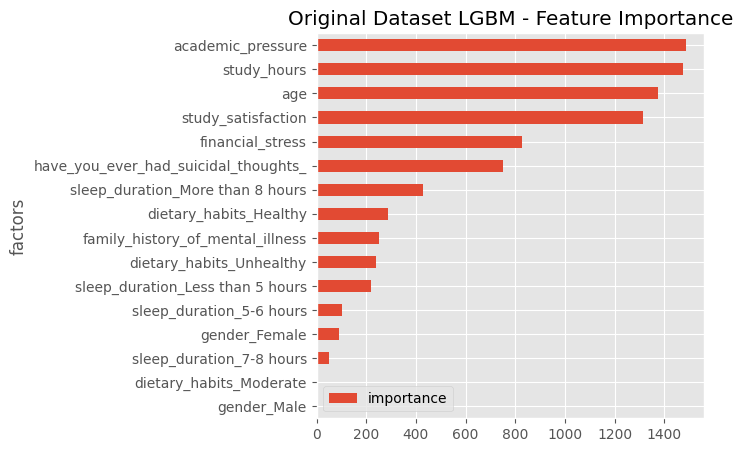

In [35]:
analysis.plot_fi(X, model, 'Original Dataset LGBM')

## KNN

In [32]:
# X and y
X_knn = knn_student.drop(columns='response')
y_knn = knn_student['response']

#Use exact train splits as original dataset - direct comparison
Xk_train = X_knn.loc[X_train.index]
yk_train = y_knn[X_train.index]

Xk_test = X_knn.loc[X_test.index]
yk_test = y_knn[X_test.index]

### Random Forest

In [ ]:
#Hyperparameter tuning with optuna 
#Create study and run trials
study = optuna.create_study(direction="maximize", study_name="RFClassifier - KNN Data")
func = lambda trial: objective_rfc(trial, Xk_train, yk_train, folds=4)
study.optimize(func, n_trials=50)

In [34]:
#Print best parameters & score
print(f'Best Accuracy: {study.best_value}')
print(f'Best Params: {study.best_params}')

Best Accuracy: 0.7880445544554455
Best Params: {'n_estimators': 100, 'max_depth': 100, 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 2}


C:\Users\Andrew\AppData\Local\Temp\ipykernel_9740\3324289224.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

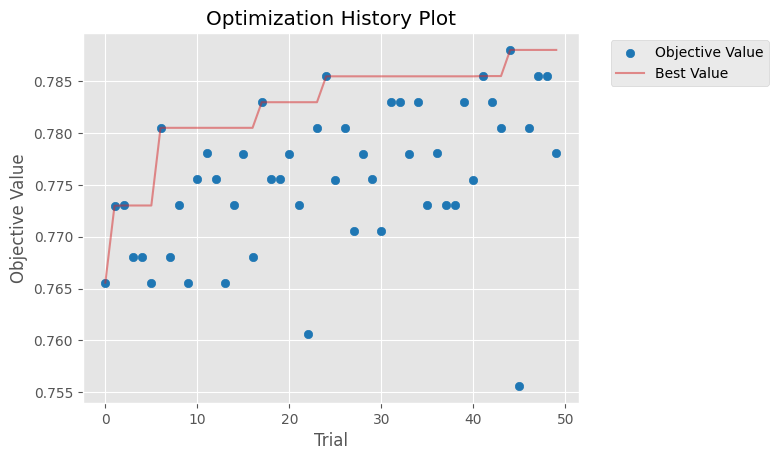

In [36]:
plot_optimization_history(study)

In [38]:
#Train model and test
model = RandomForestClassifier(bootstrap=True, 
                               random_state=5,
                               **study.best_params)
model.fit(Xk_train, yk_train)
y_pred = model.predict(Xk_test)

print(f"Test Accuracy = {accuracy_score(yk_test, y_pred)}")
print(f"Classification Report:\n {classification_report(yk_test, y_pred)}")

Test Accuracy = 0.7227722772277227
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.67      0.72        54
           1       0.67      0.79      0.73        47

    accuracy                           0.72       101
   macro avg       0.73      0.73      0.72       101
weighted avg       0.73      0.72      0.72       101



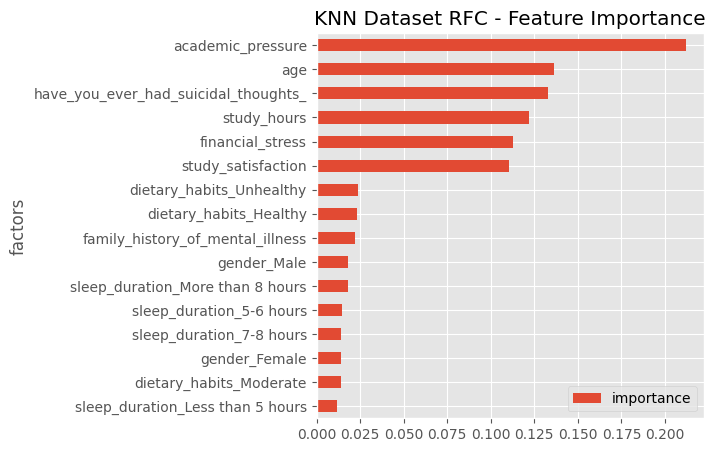

In [39]:
analysis.plot_fi(X_knn, model, 'KNN Dataset RFC')

## Iterative Imputer

In [23]:
# X and y
Xm = mice_student.drop(columns='response')
ym = mice_student['response']

#Use exact train splits as original dataset - direct comparison
Xm_train = Xm.loc[X_train.index]
ym_train = ym[X_train.index]

Xm_test = Xm.loc[X_test.index]
ym_test = ym[X_test.index]

### Random Forest

In [ ]:
#Hyperparameter tuning with optuna 
#Create study and run trials
study = optuna.create_study(direction="maximize", study_name="RFClassifier - MICE Data")
func = lambda trial: objective_rfc(trial, Xm_train, ym_train, folds=4)
study.optimize(func, n_trials=50)

In [25]:
#Print best parameters & score
print(f'Best Accuracy: {study.best_value}')
print(f'Best Params: {study.best_params}')

Best Accuracy: 0.802970297029703
Best Params: {'n_estimators': 150, 'max_depth': 68, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 7}


C:\Users\Andrew\AppData\Local\Temp\ipykernel_9740\3324289224.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

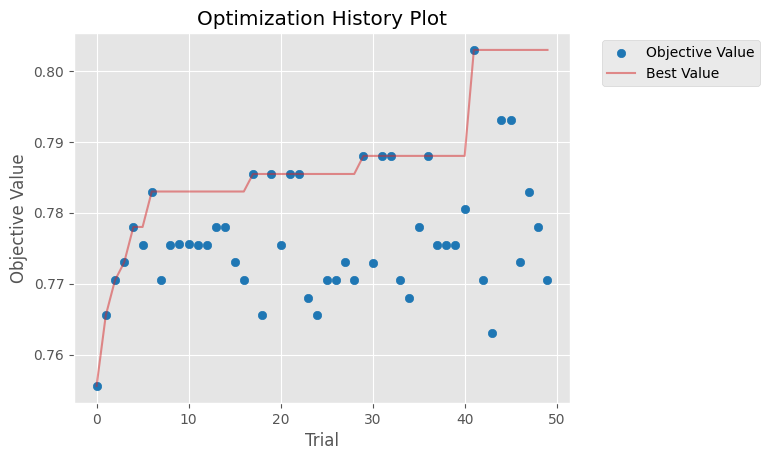

In [26]:
plot_optimization_history(study)

In [28]:
#Train model and test
model = RandomForestClassifier(bootstrap=True, 
                               random_state=5,
                               **study.best_params)
model.fit(Xm_train, ym_train)
y_pred = model.predict(Xm_test)

print(f"Test Accuracy = {accuracy_score(ym_test, y_pred)}")
print(f"Classification Report:\n {classification_report(ym_test, y_pred)}")

Test Accuracy = 0.7326732673267327
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.74      0.75        54
           1       0.71      0.72      0.72        47

    accuracy                           0.73       101
   macro avg       0.73      0.73      0.73       101
weighted avg       0.73      0.73      0.73       101



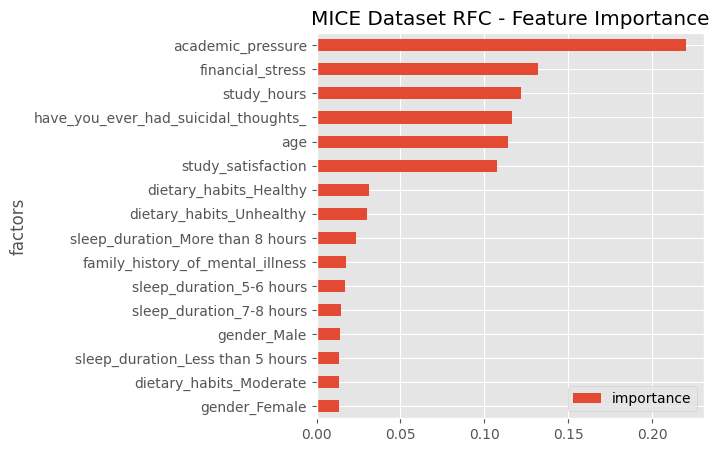

In [31]:
analysis.plot_fi(Xm, model, 'MICE Dataset RFC')

## SVT

In [6]:
# X and y
Xs = svt_student.drop(columns='response')
ys = svt_student['response']

#Use exact train splits as original dataset - direct comparison
Xs_train = Xs.loc[X_train.index]
ys_train = ys[X_train.index]

Xs_test = Xs.loc[X_test.index]
ys_test = ys[X_test.index]

### Random Forest 

In [ ]:
#Hyperparameter tuning with optuna 
#Create study and run trials
study = optuna.create_study(direction="maximize", study_name="RFClassifier - SVT Data")
func = lambda trial: objective_rfc(trial, Xs_train, ys_train, folds=4)
study.optimize(func, n_trials=50)

In [16]:
#Print best parameters & score
print(f'Best Accuracy: {study.best_value}')
print(f'Best Params: {study.best_params}')

Best Accuracy: 0.7880445544554455
Best Params: {'n_estimators': 600, 'max_depth': 46, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 3}


C:\Users\Andrew\AppData\Local\Temp\ipykernel_9740\3324289224.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

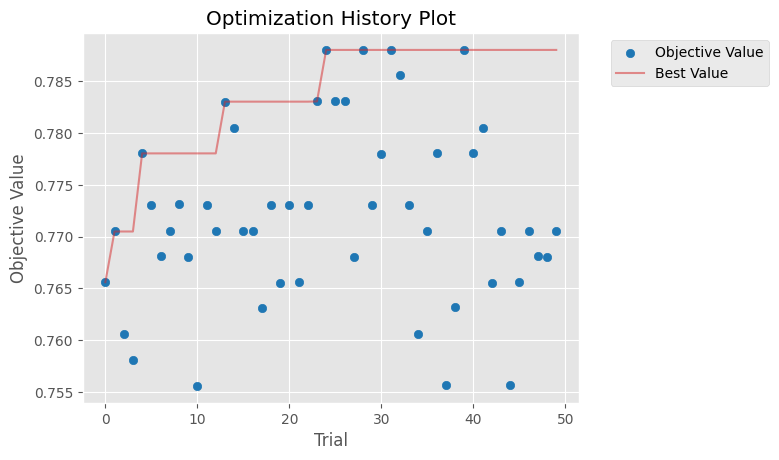

In [17]:
plot_optimization_history(study)

In [19]:
#Train model and test
model = RandomForestClassifier(bootstrap=True, 
                               random_state=5,
                               **study.best_params)
model.fit(Xs_train, ys_train)
y_pred = model.predict(Xs_test)

print(f"Test Accuracy = {accuracy_score(ys_test, y_pred)}")
print(f"Classification Report:\n {classification_report(ys_test, y_pred)}")

Test Accuracy = 0.7524752475247525
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.69      0.75        54
           1       0.70      0.83      0.76        47

    accuracy                           0.75       101
   macro avg       0.76      0.76      0.75       101
weighted avg       0.76      0.75      0.75       101



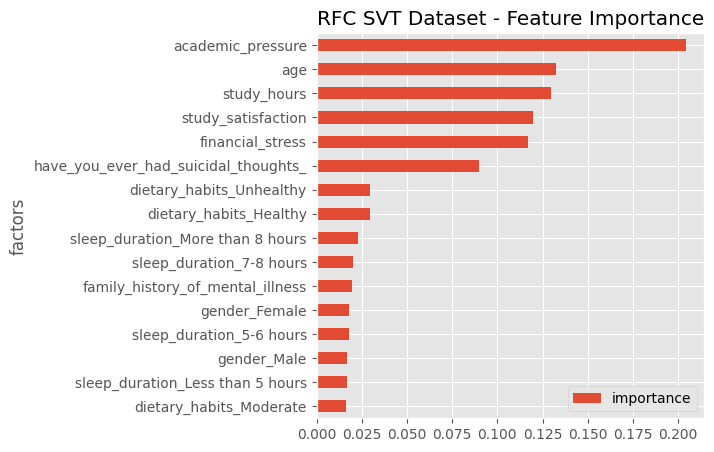

In [20]:
analysis.plot_fi(Xs, model, 'RFC SVT Dataset')

# Feature Relationships

In [94]:
#Discrete and continuous cols
student_continuous = ['age', 'academic_pressure', 'study_satisfaction',	'study_hours', 'financial_stress']
student_discrete = [col for col in original_student.columns if col not in student_continuous]
student_continuous = student_continuous + ['response']

## Pearson Correlations

In [44]:
# original_student[student_continuous].corr()

In [45]:
# knn_student[student_continuous].corr()

In [46]:
# mice_student[student_continuous].corr()

In [47]:
# svt_student[student_continuous].corr()

## Mutual Information

In [99]:
#Feature selection
from sklearn.feature_selection import SelectKBest
#anova f and mutual information
from sklearn.feature_selection import f_classif, mutual_info_classif

In [100]:
#Original 
#Initialize
mi = SelectKBest(score_func=mutual_info_classif, k='all')
mi.fit(X, y)
#MI df 
mi_df = pd.DataFrame({"feature":X.columns, 
                     "mi": mi.scores_}).sort_values(by='mi', ascending=False)

mi_df

,feature,mi
3,have_you_ever_had_suicidal_thoughts_,0.130290
1,academic_pressure,0.116864
2,study_satisfaction,0.091338
5,financial_stress,0.040927
10,sleep_duration_7-8 hours,0.039158
13,dietary_habits_Healthy,0.022396
0,age,0.022064
4,study_hours,0.015389
6,family_history_of_mental_illness,0.012682
7,gender_Female,0.000000


In [101]:
#KNN
#Initialize
mi = SelectKBest(score_func=mutual_info_classif, k='all')
mi.fit(X_knn, y_knn)
#MI df 
mi_df = pd.DataFrame({"feature":X.columns, 
                     "mi": mi.scores_}).sort_values(by='mi', ascending=False)

mi_df

,feature,mi
3,have_you_ever_had_suicidal_thoughts_,0.069825
1,academic_pressure,0.066553
2,study_satisfaction,0.033503
9,sleep_duration_5-6 hours,0.027473
14,dietary_habits_Moderate,0.023457
10,sleep_duration_7-8 hours,0.019835
5,financial_stress,0.016957
8,gender_Male,0.014979
0,age,0.009167
4,study_hours,0.005250


In [102]:
#MICE 
#Initialize
mi = SelectKBest(score_func=mutual_info_classif, k='all')
mi.fit(Xm, ym)
#MI df 
mi_df = pd.DataFrame({"feature":X.columns, 
                     "mi": mi.scores_}).sort_values(by='mi', ascending=False)
mi_df

,feature,mi
1,academic_pressure,0.051374
5,financial_stress,0.051023
3,have_you_ever_had_suicidal_thoughts_,0.038441
2,study_satisfaction,0.033628
10,sleep_duration_7-8 hours,0.033155
0,age,0.016830
4,study_hours,0.006749
6,family_history_of_mental_illness,0.000000
7,gender_Female,0.000000
8,gender_Male,0.000000


In [103]:
#SVT 
#Initialize
mi = SelectKBest(score_func=mutual_info_classif, k='all')
mi.fit(Xs, ys)
#MI df 
mi_df = pd.DataFrame({"feature":X.columns, 
                     "mi": mi.scores_}).sort_values(by='mi', ascending=False)
mi_df

,feature,mi
3,have_you_ever_had_suicidal_thoughts_,0.056423
1,academic_pressure,0.055127
2,study_satisfaction,0.049839
7,gender_Female,0.034088
8,gender_Male,0.033999
13,dietary_habits_Healthy,0.033280
4,study_hours,0.021672
0,age,0.021156
12,sleep_duration_More than 8 hours,0.020690
5,financial_stress,0.017556


## Distributions

### Feature Distributions

Text(0.5, 1.0, 'SVT Dataset')

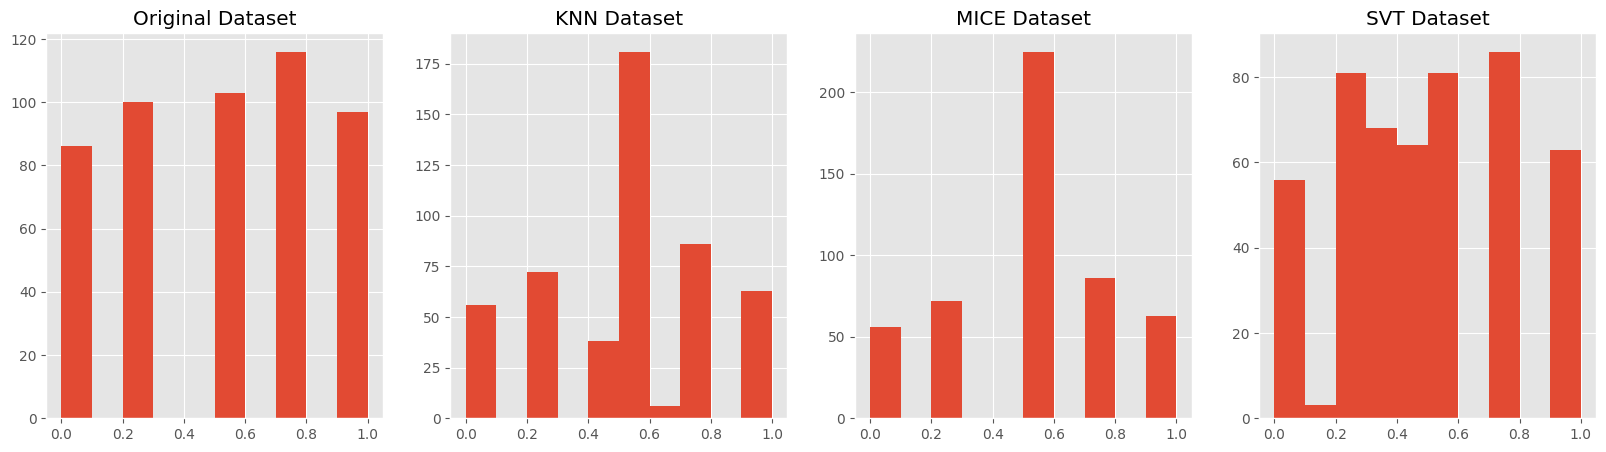

In [ ]:
#Academic Pressure
feature = 'academic_pressure'
#Plot all histograms 
#Subplots
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

#Original dataset
axes[0].hist(original_student[feature])
axes[0].set_title("Original Dataset")

#KNN dataset
axes[1].hist(knn_student[feature])
axes[1].set_title("KNN Dataset")

#MICE dataset
axes[2].hist(mice_student[feature])
axes[2].set_title("MICE Dataset")

#SVT dataset
axes[3].hist(svt_student[feature])
axes[3].set_title("SVT Dataset")

In [51]:
# #Study Satisfaction 
# feature = 'study_satisfaction'

# #Plot all histograms 
# #Subplots
# fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# #Original dataset
# axes[0].hist(original_student[feature])
# axes[0].set_title("Original Dataset")

# #KNN dataset
# axes[1].hist(knn_student[feature])
# axes[1].set_title("KNN Dataset")

# #MICE dataset
# axes[2].hist(mice_student[feature])
# axes[2].set_title("MICE Dataset")

# #SVT dataset
# axes[3].hist(svt_student[feature])
# axes[3].set_title("SVT Dataset")


In [48]:
# #Financial Stress
# feature = 'financial_stress'

# #Plot all histograms 
# #Subplots
# fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# #Original dataset
# axes[0].hist(original_student[feature])
# axes[0].set_title("Original Dataset")

# #KNN dataset
# axes[1].hist(knn_student[feature])
# axes[1].set_title("KNN Dataset")

# #MICE dataset
# axes[2].hist(mice_student[feature])
# axes[2].set_title("MICE Dataset")

# #SVT dataset
# axes[3].hist(svt_student[feature])
# axes[3].set_title("SVT Dataset")

### Density Plots

Text(0.5, 1.0, 'SVT Dataset')

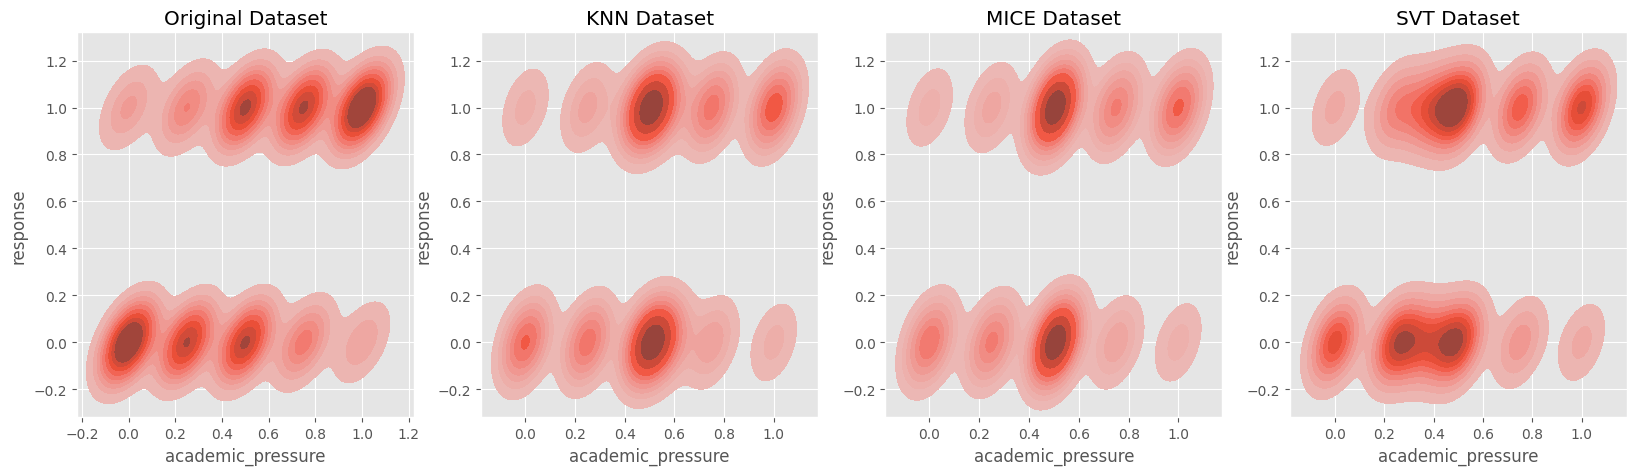

In [188]:
#Academic Pressure
feature = 'academic_pressure'

#Plot all histograms 
#Subplots
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

#Original Dataset
sns.kdeplot(ax=axes[0], data=original_student, x=original_student[feature], y=original_student['response'], bw_adjust=0.6, fill=True)
axes[0].set_title('Original Dataset')

#KNN Dataset
sns.kdeplot(ax=axes[1], data=knn_student, x=knn_student[feature], y=knn_student['response'], bw_adjust=0.6, fill=True)
axes[1].set_title('KNN Dataset')

#MICE Dataset
sns.kdeplot(ax=axes[2], data=mice_student, x=mice_student[feature], y=mice_student['response'], bw_adjust=0.6, fill=True)
axes[2].set_title('MICE Dataset')

#SVT Dataset
sns.kdeplot(ax=axes[3], data=svt_student, x=svt_student[feature], y=svt_student['response'], bw_adjust=0.6, fill=True)
axes[3].set_title('SVT Dataset')

In [50]:
# #Academic Pressure
# feature = 'study_satisfaction'

# #Plot all histograms 
# #Subplots
# fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# #Original Dataset
# sns.kdeplot(ax=axes[0], data=original_student, x=original_student[feature], y=original_student['response'], bw_adjust=0.6, fill=True)
# axes[0].set_title('Original Dataset')

# #KNN Dataset
# sns.kdeplot(ax=axes[1], data=knn_student, x=knn_student[feature], y=knn_student['response'], bw_adjust=0.6, fill=True)
# axes[1].set_title('KNN Dataset')

# #MICE Dataset
# sns.kdeplot(ax=axes[2], data=mice_student, x=mice_student[feature], y=mice_student['response'], bw_adjust=0.6, fill=True)
# axes[2].set_title('MICE Dataset')

# #SVT Dataset
# sns.kdeplot(ax=axes[3], data=svt_student, x=svt_student[feature], y=svt_student['response'], bw_adjust=0.6, fill=True)
# axes[3].set_title('SVT Dataset')

In [49]:
# #Academic Pressure
# feature = 'financial_stress'

# #Plot all histograms 
# #Subplots
# fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# #Original Dataset
# sns.kdeplot(ax=axes[0], data=original_student, x=original_student[feature], y=original_student['response'], bw_adjust=0.6, fill=True)
# axes[0].set_title('Original Dataset')

# #KNN Dataset
# sns.kdeplot(ax=axes[1], data=knn_student, x=knn_student[feature], y=knn_student['response'], bw_adjust=0.6, fill=True)
# axes[1].set_title('KNN Dataset')

# #MICE Dataset
# sns.kdeplot(ax=axes[2], data=mice_student, x=mice_student[feature], y=mice_student['response'], bw_adjust=0.6, fill=True)
# axes[2].set_title('MICE Dataset')

# #SVT Dataset
# sns.kdeplot(ax=axes[3], data=svt_student, x=svt_student[feature], y=svt_student['response'], bw_adjust=0.6, fill=True)
# axes[3].set_title('SVT Dataset')

## PCA

In [159]:
from sklearn.decomposition import PCA
import plotly.express as px

### 2D representation

<Axes: xlabel='pc0', ylabel='pc1'>

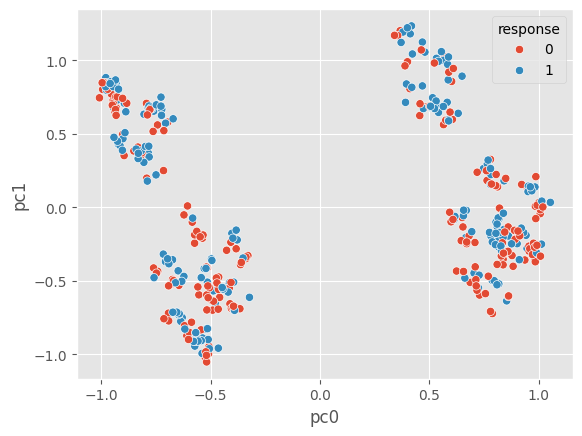

In [166]:
#Original Dataset
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

#Create df for plotting 
pca_df = pd.DataFrame(X_pca)
pca_df['response'] = y_train.reset_index(drop=True)

#Visualize
pca_df.columns = pca_df.columns.astype('str')
pca_df.rename(columns={'0':'pc0',
                       '1':'pc1'}, inplace=True)

#Plot principal components and decision boundaries 
sns.scatterplot(data=pca_df, x='pc0', y='pc1', hue='response')

<Axes: xlabel='pc0', ylabel='pc1'>

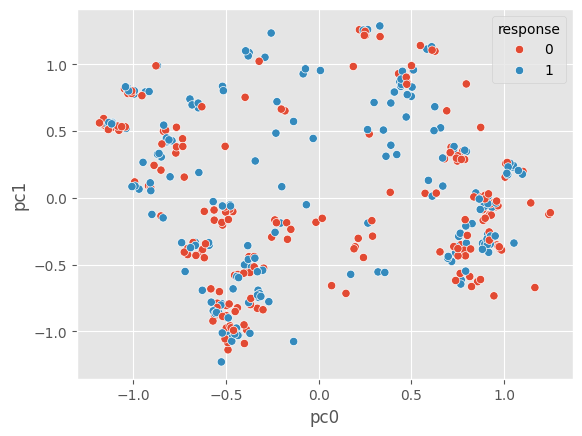

In [167]:
#KNN Dataset
pca = PCA(n_components=2)
Xk_pca = pca.fit_transform(Xk_train)

#Create df for plotting 
pca_df = pd.DataFrame(Xk_pca)
pca_df['response'] = yk_train.reset_index(drop=True)

#Visualize
pca_df.columns = pca_df.columns.astype('str')
pca_df.rename(columns={'0':'pc0',
                       '1':'pc1'}, inplace=True)

#Plot principal components and decision boundaries 
sns.scatterplot(data=pca_df, x='pc0', y='pc1', hue='response')

<Axes: xlabel='pc0', ylabel='pc1'>

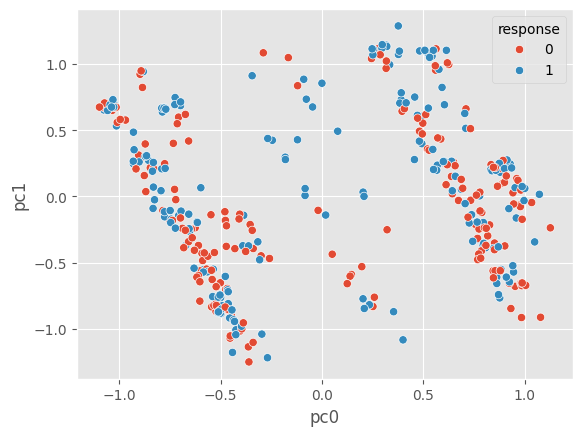

In [168]:
#MICE Dataset
pca = PCA(n_components=2)
Xm_pca = pca.fit_transform(Xm_train)

#Create df for plotting 
pca_df = pd.DataFrame(Xm_pca)
pca_df['response'] = ym_train.reset_index(drop=True)

#Visualize
pca_df.columns = pca_df.columns.astype('str')
pca_df.rename(columns={'0':'pc0',
                       '1':'pc1'}, inplace=True)

#Plot principal components and decision boundaries 
sns.scatterplot(data=pca_df, x='pc0', y='pc1', hue='response')

<Axes: xlabel='pc0', ylabel='pc1'>

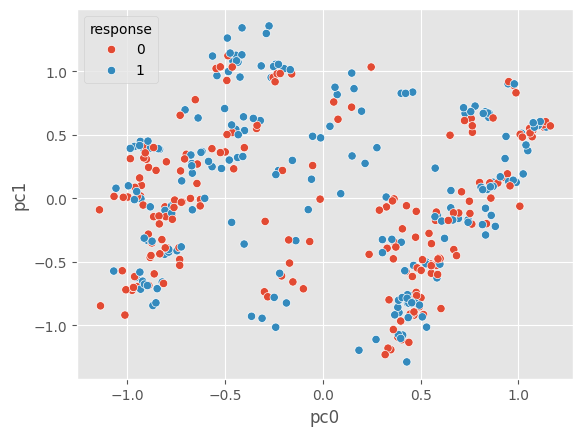

In [169]:
#SVT Dataset
pca = PCA(n_components=2)
Xs_pca = pca.fit_transform(Xs_train)

#Create df for plotting 
pca_df = pd.DataFrame(Xs_pca)
pca_df['response'] = ys_train.reset_index(drop=True)

#Visualize
pca_df.columns = pca_df.columns.astype('str')
pca_df.rename(columns={'0':'pc0',
                       '1':'pc1'}, inplace=True)

#Plot principal components and decision boundaries 
sns.scatterplot(data=pca_df, x='pc0', y='pc1', hue='response')

### 3D Representation

In [40]:
# #Original Dataset
# pca = PCA(n_components=3)
# X_pca = pca.fit_transform(X_train)

# #Create df for plotting 
# pca_df = pd.DataFrame(X_pca)
# pca_df['response'] = y_train.reset_index(drop=True)

# #Visualize
# pca_df.columns = pca_df.columns.astype('str')
# pca_df.rename(columns={'0':'pc0',
#                        '1':'pc1', 
#                        '2':'pc2'}, inplace=True)


# fig = px.scatter_3d(pca_df, x='pc0', y='pc1', z='pc2', color='response')
# fig.show()

In [41]:
# #KNN Dataset
# pca = PCA(n_components=3)
# Xk_pca = pca.fit_transform(Xk_train)

# #Create df for plotting 
# pca_df = pd.DataFrame(Xk_pca)
# pca_df['response'] = yk_train.reset_index(drop=True)

# #Visualize
# pca_df.columns = pca_df.columns.astype('str')
# pca_df.rename(columns={'0':'pc0',
#                        '1':'pc1', 
#                        '2':'pc2'}, inplace=True)


# fig = px.scatter_3d(pca_df, x='pc0', y='pc1', z='pc2', color='response')
# fig.show()

In [42]:
# #MICE Dataset
# pca = PCA(n_components=3)
# Xm_pca = pca.fit_transform(Xm_train)

# #Create df for plotting 
# pca_df = pd.DataFrame(Xm_pca)
# pca_df['response'] = ym_train.reset_index(drop=True)

# #Visualize
# pca_df.columns = pca_df.columns.astype('str')
# pca_df.rename(columns={'0':'pc0',
#                        '1':'pc1', 
#                        '2':'pc2'}, inplace=True)


# fig = px.scatter_3d(pca_df, x='pc0', y='pc1', z='pc2', color='response')
# fig.show()

In [ ]:
# #SVT Dataset
# pca = PCA(n_components=3)
# Xs_pca = pca.fit_transform(Xs_train)

# #Create df for plotting 
# pca_df = pd.DataFrame(Xs_pca)
# pca_df['response'] = ys_train.reset_index(drop=True)

# #Visualize
# pca_df.columns = pca_df.columns.astype('str')
# pca_df.rename(columns={'0':'pc0',
#                        '1':'pc1', 
#                        '2':'pc2'}, inplace=True)


# fig = px.scatter_3d(pca_df, x='pc0', y='pc1', z='pc2', color='response')
# fig.show()